In [1]:
# Step 1: Basic setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
)

import xgboost as xgb

# Display options for clean outputs
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8")

# Load dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Quick shape and head
print("Shape:", df.shape)
df.head()


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
# Step 2.1: High level info
print("Columns:\n", df.columns.tolist(), "\n")

print("Data types and non-null counts:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nUnique values for some key columns:")
for col in ["gender", "SeniorCitizen", "Partner", "Dependents",
            "PhoneService", "MultipleLines", "InternetService",
            "Contract", "PaymentMethod", "Churn"]:
    print(f"\n{col} -> {df[col].unique()}")


Columns:
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'] 

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   Onl

In [3]:
# Step 2.2.1: Fix TotalCharges (some spaces / empty strings)

print("Before cleaning:", df["TotalCharges"].dtype)

# Convert to numeric; errors='coerce' will turn bad values into NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

print("After cleaning:", df["TotalCharges"].dtype)
print("Missing TotalCharges:", df["TotalCharges"].isna().sum())

# Remove rows where TotalCharges is NaN (very few rows)
df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)
print("Shape after dropping NaNs:", df.shape)


Before cleaning: object
After cleaning: float64
Missing TotalCharges: 11
Shape after dropping NaNs: (7032, 21)


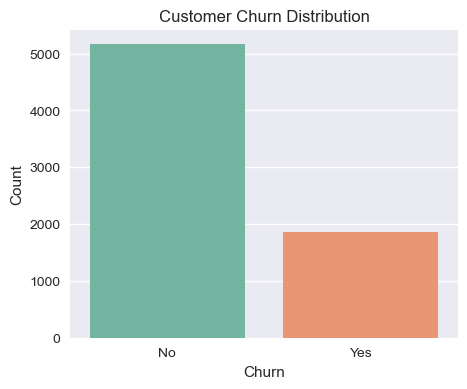

Churn rate (%):
 Churn
No     73.421502
Yes    26.578498
Name: proportion, dtype: float64


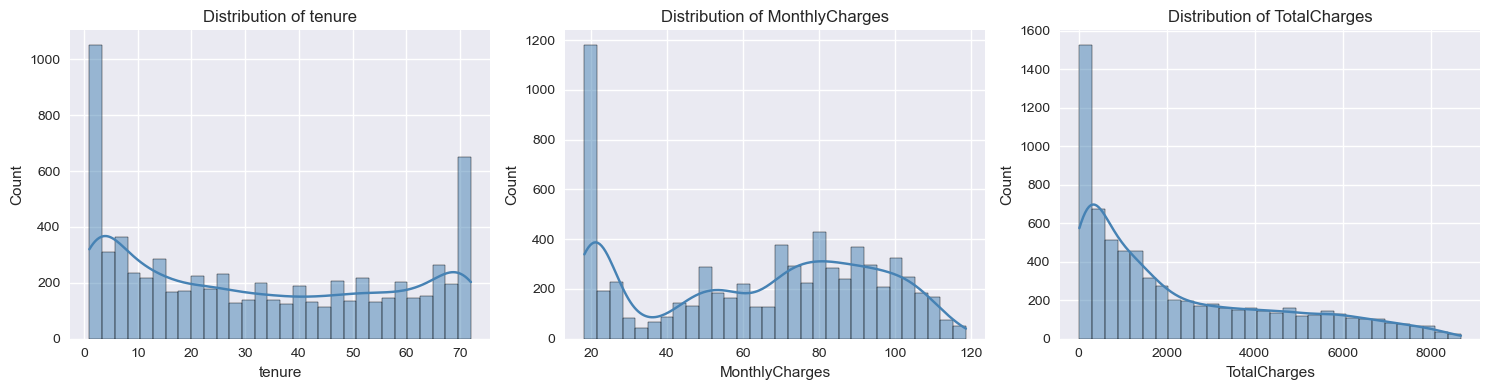

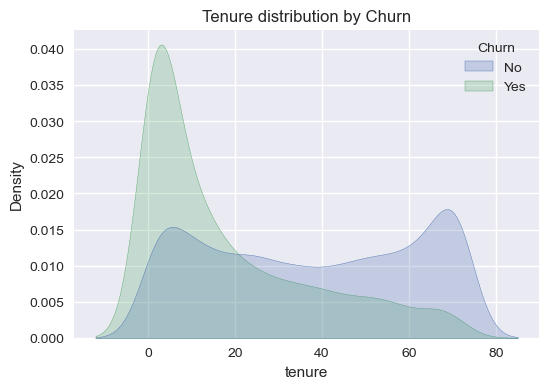

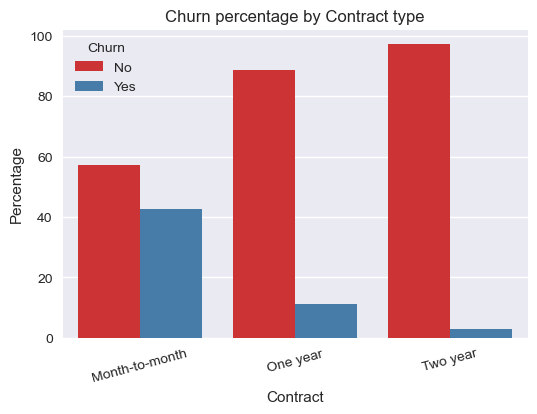

In [5]:
# Step 3.1: Target variable distribution (Churn)
plt.figure(figsize=(5,4))
sns.countplot(data=df, x="Churn", hue="Churn", legend=False, palette="Set2")

plt.title("Customer Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

churn_rate = df["Churn"].value_counts(normalize=True) * 100
print("Churn rate (%):\n", churn_rate)

# Step 3.2: Numerical features distribution
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

plt.figure(figsize=(15,4))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color="steelblue")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Step 3.3: Churn vs tenure
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x="tenure", hue="Churn", common_norm=False, fill=True)
plt.title("Tenure distribution by Churn")
plt.show()

# Step 3.4: Churn vs Contract type
plt.figure(figsize=(6,4))
contract_churn = (
    df.groupby("Contract")["Churn"]
      .value_counts(normalize=True)
      .rename("percentage")
      .mul(100)
      .reset_index()
)

sns.barplot(data=contract_churn, x="Contract", y="percentage",
            hue="Churn", palette="Set1")
plt.title("Churn percentage by Contract type")
plt.ylabel("Percentage")
plt.xticks(rotation=15)
plt.show()


In [6]:
# Step 4.1: Drop ID column
df_model = df.drop(columns=["customerID"])

# Step 4.2: Binary encode 'Churn' (Yes=1, No=0)
df_model["Churn"] = df_model["Churn"].map({"Yes": 1, "No": 0})

# Step 4.3: Identify categorical & numerical columns
cat_cols = df_model.select_dtypes(include=["object"]).columns.tolist()
num_cols = df_model.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_cols.remove("Churn")

print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)

# Step 4.4: One‑hot encoding
df_encoded = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

print("Shape after encoding:", df_encoded.shape)
df_encoded.head()


Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Shape after encoding: (7032, 31)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False


Train shape: (5625, 30)  Test shape: (1407, 30)
=== Logistic Regression Performance ===
Accuracy : 0.8053
Precision: 0.6515
Recall   : 0.5749
F1-score : 0.6108
ROC-AUC  : 0.8361

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.81      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.81      0.80      1407



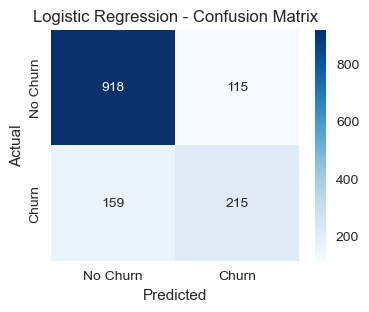

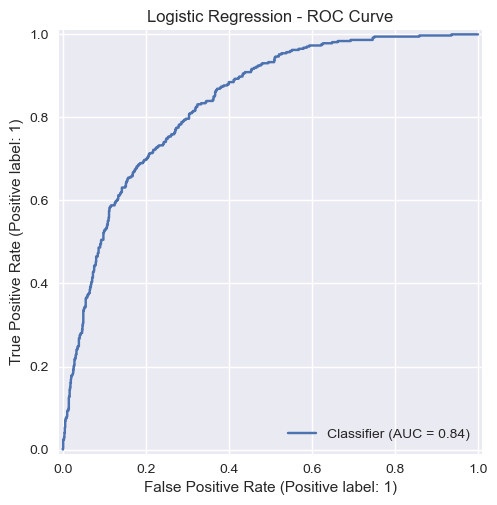

In [8]:
from sklearn.linear_model import LogisticRegression

# Step 5.1: Split features and target
X = df_encoded.drop(columns=["Churn"])
y = df_encoded["Churn"]

# Step 5.2: Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

# Step 5.3: Feature scaling (only for numeric columns)
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# Step 5.4: Train Logistic Regression
log_reg = LogisticRegression(max_iter=500, n_jobs=-1)
log_reg.fit(X_train_scaled, y_train)

# Step 5.5: Predictions and probabilities
y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Step 5.6: Evaluation metrics function
def evaluate_model(y_true, y_pred, y_proba, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    print(f"=== {model_name} Performance ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}\n")

    print("Classification report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Churn", "Churn"],
                yticklabels=["No Churn", "Churn"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title(f"{model_name} - ROC Curve")
    plt.show()

# Step 5.7: Evaluate Logistic Regression
evaluate_model(y_test, y_pred_lr, y_proba_lr, model_name="Logistic Regression")


[0]	train-auc:0.83122	test-auc:0.81277
[50]	train-auc:0.86709	test-auc:0.84077
[100]	train-auc:0.87880	test-auc:0.84065
[150]	train-auc:0.88932	test-auc:0.83812
[200]	train-auc:0.89773	test-auc:0.83588
[250]	train-auc:0.90439	test-auc:0.83368
[299]	train-auc:0.91038	test-auc:0.83187
=== XGBoost Performance ===
Accuracy : 0.7839
Precision: 0.6101
Recall   : 0.5187
F1-score : 0.5607
ROC-AUC  : 0.8319

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1033
           1       0.61      0.52      0.56       374

    accuracy                           0.78      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.77      0.78      0.78      1407



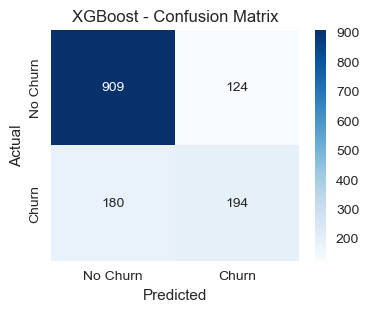

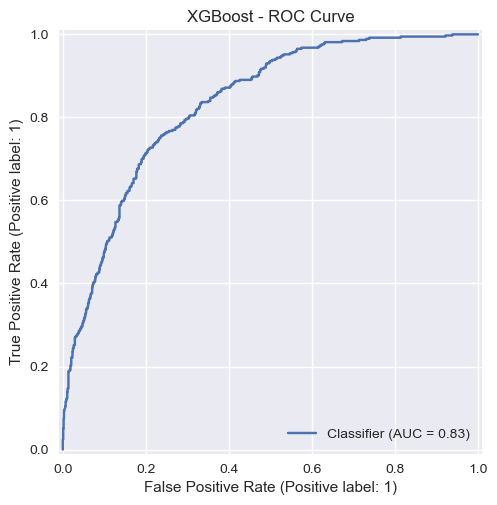

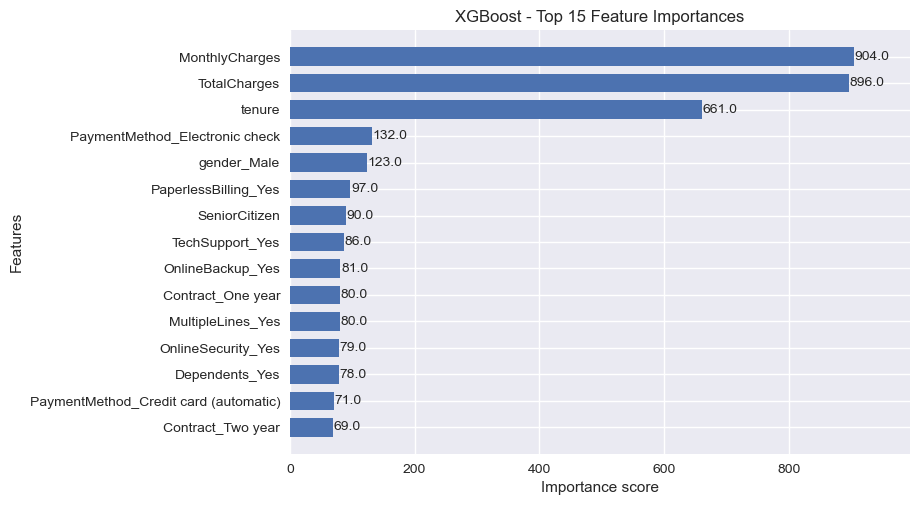

In [9]:
# Step 6.1: Prepare DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Step 6.2: XGBoost parameters (basic but solid)
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.05,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "random_state": 42,
}

evals = [(dtrain, "train"), (dtest, "test")]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=300,
    evals=evals,
    verbose_eval=50
)

# Step 6.3: Predictions
y_proba_xgb = xgb_model.predict(dtest)
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)

# Step 6.4: Evaluate XGBoost using same function
evaluate_model(y_test, y_pred_xgb, y_proba_xgb, model_name="XGBoost")

# Step 6.5: Feature importance plot
xgb.plot_importance(xgb_model, max_num_features=15, height=0.7)
plt.title("XGBoost - Top 15 Feature Importances")
plt.show()


In [10]:
# Step 7.1: Collect metrics for both models
def get_metrics_dict(y_true, y_pred, y_proba, name):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba),
    }

metrics_lr = get_metrics_dict(y_test, y_pred_lr, y_proba_lr, "Logistic Regression")
metrics_xgb = get_metrics_dict(y_test, y_pred_xgb, y_proba_xgb, "XGBoost")

metrics_df = pd.DataFrame([metrics_lr, metrics_xgb])
metrics_df


,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.805259,0.651515,0.574866,0.610795,0.836074
1,XGBoost,0.783937,0.610063,0.518717,0.560694,0.831873


In [11]:
# Step 8.1: Choose final model
final_model = log_reg
final_scaler = scaler
final_features = X.columns

# Step 8.2: Take one random customer from test set
sample = X_test.sample(1, random_state=42)
sample_original = sample.copy()  # for display

# Scale numeric columns
sample_scaled = sample.copy()
sample_scaled[num_cols] = final_scaler.transform(sample[num_cols])

# Predict
proba = final_model.predict_proba(sample_scaled)[:, 1][0]
pred = final_model.predict(sample_scaled)[0]

print("Sample customer features:")
display(sample_original)

print(f"\nPredicted churn probability: {proba:.3f}")
print("Predicted label:", "Churn" if pred == 1 else "No Churn")


Sample customer features:


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6959,0,4,74.35,265.35,True,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False



Predicted churn probability: 0.733
Predicted label: Churn


In [14]:
def predict_churn_from_raw(input_dict):
    """
    input_dict: raw feature values in same format as original df (except customerID).
    Returns (probability, label).
    """
    new_df = pd.DataFrame([input_dict])

    # Clean TotalCharges
    new_df["TotalCharges"] = pd.to_numeric(new_df["TotalCharges"], errors="coerce")
    new_df = new_df.dropna(subset=["TotalCharges"])

    # One‑hot encoding
    new_df_enc = pd.get_dummies(new_df, columns=cat_cols, drop_first=True)

    # Add missing columns
    for col in final_features:
        if col not in new_df_enc.columns:
            new_df_enc[col] = 0

    new_df_enc = new_df_enc[final_features]

    # Scale numeric columns
    new_df_enc[num_cols] = final_scaler.transform(new_df_enc[num_cols])

    proba = final_model.predict_proba(new_df_enc)[:, 1][0]
    label = "Churn" if proba >= 0.5 else "No Churn"
    return proba, label


In [36]:
example_customer = {
    "gender": "male",
    "SeniorCitizen": 1,
    "Partner": "Yes",
    "Dependents": "No",
    "tenure": 10,
    "PhoneService": "Yes",
    "MultipleLines": "No",
    "InternetService": "Fiber optic",
    "OnlineSecurity": "yes",
    "OnlineBackup": "yes",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "Yes",
    "StreamingMovies": "Yes",
    "Contract": "Month-to-month",
    "PaperlessBilling": "no",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 80.0,
    "TotalCharges": 40.0,
}

proba, label = predict_churn_from_raw(example_customer)
print(f"Predicted probability: {proba:.3f}, label: {label}")


Predicted probability: 0.295, label: No Churn


In [37]:
high_risk_customer = {
    "gender": "Female",
    "SeniorCitizen": 1,
    "Partner": "No",
    "Dependents": "No",
    "tenure": 1,
    "PhoneService": "Yes",
    "MultipleLines": "No",
    "InternetService": "Fiber optic",
    "OnlineSecurity": "No",
    "OnlineBackup": "No",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "Yes",
    "StreamingMovies": "Yes",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 95.0,
    "TotalCharges": 95.0,
}
proba, label = predict_churn_from_raw(high_risk_customer)
print(f"Predicted probability: {proba:.3f}, label: {label}")

Predicted probability: 0.360, label: No Churn


In [38]:
very_low_risk_customer = {
    "gender": "Male",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "Yes",
    "tenure": 60,
    "PhoneService": "Yes",
    "MultipleLines": "Yes",
    "InternetService": "DSL",
    "OnlineSecurity": "Yes",
    "OnlineBackup": "Yes",
    "DeviceProtection": "Yes",
    "TechSupport": "Yes",
    "StreamingTV": "Yes",
    "StreamingMovies": "Yes",
    "Contract": "Two year",
    "PaperlessBilling": "No",
    "PaymentMethod": "Credit card (automatic)",
    "MonthlyCharges": 70.0,
    "TotalCharges": 4000.0,
}
proba, label = predict_churn_from_raw(very_low_risk_customer)
print(f"Predicted probability: {proba:.3f}, label: {label}")

Predicted probability: 0.071, label: No Churn
